alpha= 6.250
CNFDM Price :  0.4420
Exact BS Price :  0.4420


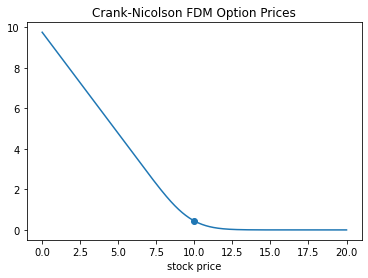

In [3]:
# Example: BS Option Price Using Crank-Nicolson

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


def Thomas_Algorithm(a, b, c, d):

    ne = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, ne):   
        ac[it] = a[it] - b[it]*(c[it-1]/ac[it-1]) 
        dc[it] = d[it] - b[it]*(dc[it-1]/ac[it-1])

    xc = np.zeros(ne)
    xc[-1] = dc[-1]/ac[-1]
    for il in range(ne-2, -1, -1):
        xc[il] = (dc[il]/ac[il]) - (c[il]/ac[il])*xc[il+1]

    return xc 

def BSprice(PutCall, x0, T, K, rf, q, sigma):
    d1 =(1/(sigma*np.sqrt(T)))*(np.log(x0/K) + (rf - q + 0.5*sigma**2)*T)
    d2 = (1/(sigma*np.sqrt(T)))*(np.log(x0/K) + (rf - q - 0.5*sigma**2)*T)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    Nd1m = norm.cdf(-d1)
    Nd2m = norm.cdf(-d2)
    
    if PutCall == 'C':
        price1 = x0*np.exp(-q*T)*Nd1 - K*np.exp(-rf*T)*Nd2
        price2 = np.exp(-q*T)*Nd1
    elif PutCall =='P':
        price1 = K*np.exp(-rf*T)*Nd2m - x0*np.exp(-q*T)*Nd1m
        price2 = -np.exp(-q*T)*Nd1m

    # price = [price1, price2]=[price,delta]
    price = np.zeros((1,2))
    price[0,0] = price1
    price[0,1] = price2
    return price            


def CNFDMf(PutCall,xmin,K,rf,q,sigma,dt,dx,N,M):
    xh = np.array(list(range(M+1)))                                         # number of node: M+1
    tk = np.array(list(range(N+1)))
    
    v = np.zeros((N+1,M+1))                                                 # solution (shape:(N+1,M+1))
    
    # BC at expiration (n=0)
    if PutCall == 'C':
        v[0,0:M+1] = np.maximum(xmin + xh*dx - K, 0)
    elif PutCall =='P':
        v[0,0:M+1] = np.maximum(K - (xmin + xh*dx), 0)
        
    # BC at x = Smax or Smin (m=M or m=0)
    if PutCall =='C':
        v[0:N+1,0] = 0                                                         # call value when underlying is 0
        v[0:N+1,M] = (xmin + M*dx)*np.exp(-q*tk*dt) - K*np.exp(-rf*tk*dt)      # call value when underlying is large 
    elif PutCall == 'P':
        v[0:N+1,0] = K*np.exp(-rf*tk*dt)                                        # put value when underlying is 0
        v[0:N+1,M] = 0                                                          # put value when underlying is large 

    
    # Coefficients of matrix for CNFDM
    a = (dt/2)*(rf + (sigma**2)*(xh**2))
    b = (dt/4)*((rf-q)*xh - (sigma**2)*(xh**2))
    c = -(dt/4)*((rf-q)*xh + (sigma**2)*(xh**2))

    # a-(b+c)>0, the matrix is strictly diagonally dominant
    d = np.zeros(M+1)
    
    for n in range (0,N):         
        d[1:M] = - np.multiply(b[1:M],v[n,0:M-1]) + np.multiply(1-a[1:M],v[n,1:M]) - np.multiply(c[1:M],v[n,2:M+1])
        d[1] = d[1] - b[1]*v[n+1,0]
        d[M-1] = d[M-1] - c[M-1]*v[n+1,M]       
        v[n+1,1:M] = Thomas_Algorithm(1 + a[1:M],b[1:M],c[1:M],d[1:M])

    price = np.zeros(M+1)
    price = v[N,0:M+1]
    return price

# European Option Pricing
PutCall = 'P'
x0 = 10
K = 10
rf = 0.05
q = 0
sigma = 0.2
T = 0.5

xmax = x0*(1 + 5*sigma)      # five times of annual volatility over half year
xmin = 0
N = 200                       # numer of time point
M = 1000                       # numer of stock price point 
dx = (xmax - xmin)/M           # S-mesh size
dt = T/N                     # t-mesh size
alpha = dt/(dx)**2           # alpha < 1/2 for stability
x0tag = 0
for i in range(M + 1):
    if i*dx < x0:
        x0tag += 1

# Plain Vanillar Option 
CNFDMprice = CNFDMf(PutCall,xmin,K,rf,q,sigma,dt,dx,N,M)

BSEprice = BSprice(PutCall,x0,T,K,rf,q,sigma)

print('alpha=',"%.3f" %alpha)
print('CNFDM Price : ', "%.4f" %CNFDMprice[x0tag])
print('Exact BS Price : ', "%.4f" %BSEprice[0,0])

# Plotting
x = np.linspace(xmin, xmax, M+1)
plt.xlabel('stock price')
plt.title('Crank-Nicolson FDM Option Prices')
plt.plot(x, CNFDMprice[:])
plt.scatter(x[x0tag], CNFDMprice[x0tag])
plt.show()